([[0.24392361111111108, 0.6796874999999999, 0.08421610169491522, 0.07421874999999994], [0.12626262626262627, 0.3768939393939394, 0.12634822804314327, 0.09848484848484844], [0.5596064814814813, 0.37326388888888884, 0.6735522598870053, 0.6679687500000001]], [2, 0, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 1, 2, 2, 1, 1, 1, 0, 2, 1, 2, 2, 0, 1, 0, 1, 0, 0, 2, 2, 1, 2, 1, 1, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])


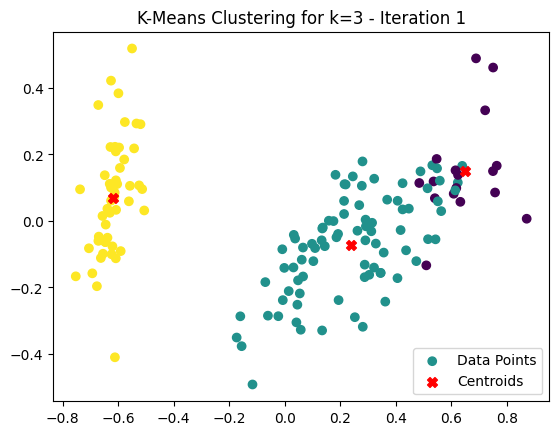

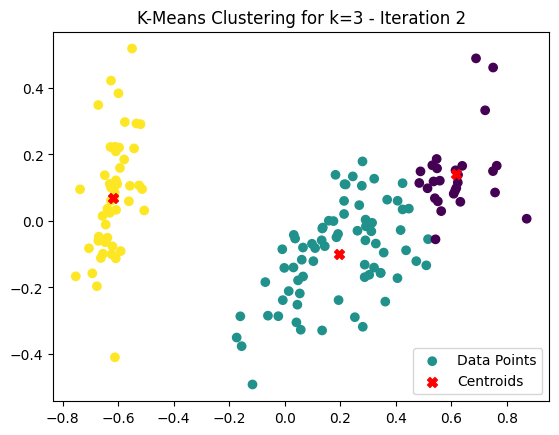

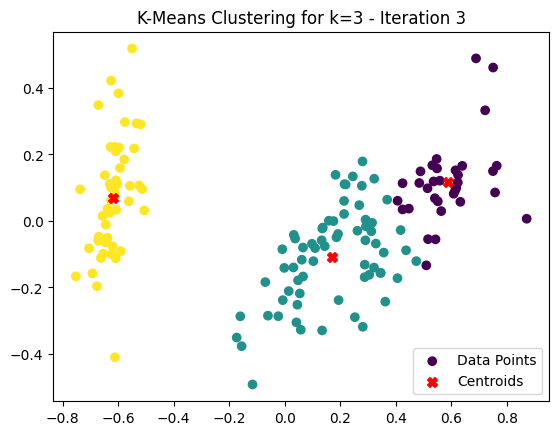

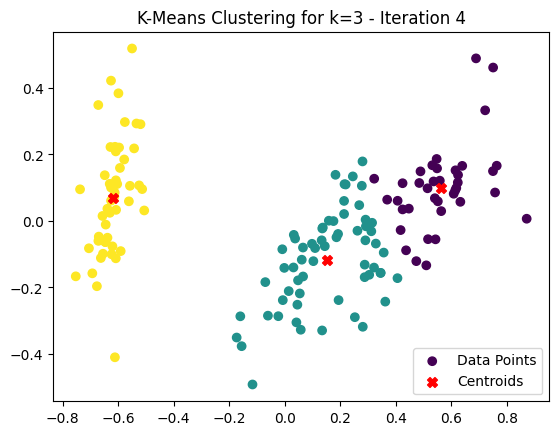

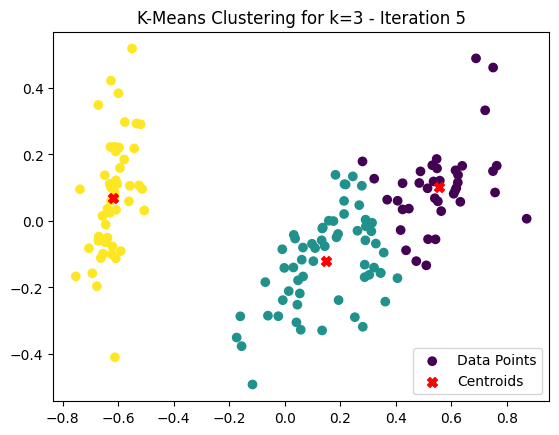

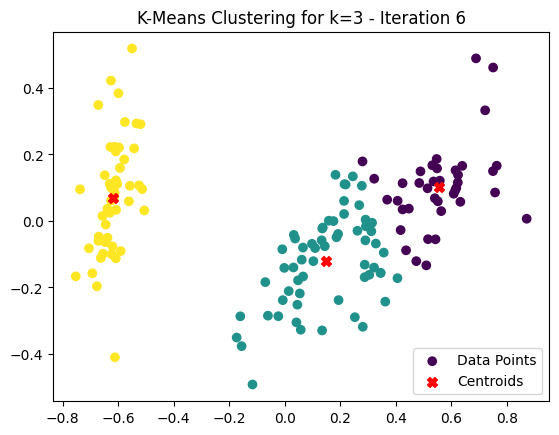

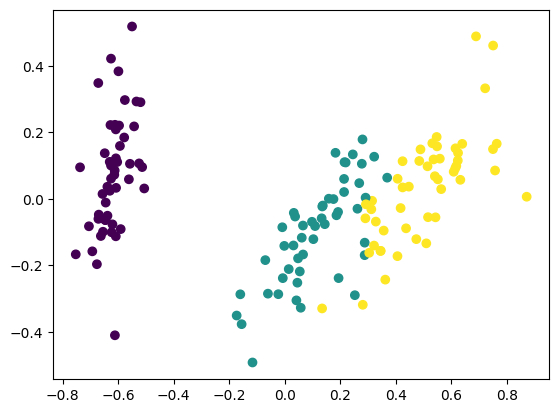

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import random
from sklearn.preprocessing import LabelEncoder

class Kmeans_iterative:
    def __init__(self, data, k=3):
        self.k = k
        self.data = data

    def calculate_distance (self, point_1, point_2):
        distance = 0
        for val1, val2 in zip(point_1, point_2):
            distance += (val1 - val2) ** 2
        return distance ** 0.5

    def initizialize_centroids(self):
        centroids = random.sample(self.data, self.k)
        return centroids

    def assign_clusters(self, centroids):
        all_centroid_distances = []

        # Calculate distances for each point and centroid
        for centroid in centroids:
            current_centroid = []
            for point in self.data:
                current_centroid.append(self.calculate_distance(centroid, point))
            all_centroid_distances.append(current_centroid)

        # Transpose the distances matrix
        all_centroid_distances_transposed = list(zip(*all_centroid_distances))

        # Assign each data point to the index of the nearest centroid
        assigned_clusters = []
        for distances in all_centroid_distances_transposed:
            # Initialize variables to keep track of the minimum distance and its index
            min_distance = float('inf')  # Set to positive infinity initially

            # Iterate over the distances to find the minimum
            for index, distance in enumerate(distances):    
                if distance < min_distance:
                    min_distance = distance
                    min_index = index
            assigned_clusters.append(min_index)

        return assigned_clusters

    def calculate_centers(self, assigned_clusters):
        new_centroids = []

        # Iterate over each cluster
        for current_cluster in range(self.k):
            current_cluster_points = []

            # Collect points for the current cluster
            for point, cluster_label in zip(self.data, assigned_clusters):
                if cluster_label == current_cluster:
                    current_cluster_points.append(point)

            if current_cluster_points:
                # Calculate the mean for each dimension
                mean_values = []
                for column in zip(*current_cluster_points):     #look into this
                    mean_values.append(sum(column) / len(current_cluster_points))
                new_centroids.append(mean_values)
            else:
                # If the cluster is empty, keep the current centroid
                new_centroids.append(random.choice(self.data))

        return new_centroids

    def has_converged(self, centroids, new_centroids, tolerance=0.0001):
        for c1, c2 in zip(centroids, new_centroids):
            if self.calculate_distance(c1, c2) >= tolerance:
                return False
        return True

    def kmeans(self, max_iterations=1000):
        # Initialize centroids
        centroids = self.initizialize_centroids()

        for _ in range(max_iterations):
            # Assign data points to clusters
            assigned_clusters = self.assign_clusters(centroids)

            # Calculate new centroids
            new_centroids = self.calculate_centers(assigned_clusters)
            # Check for convergence
            if self.has_converged(centroids, new_centroids):
                break

            # Update centroids for the next iteration
            centroids = new_centroids

        return centroids, assigned_clusters

################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################


class KMeansVectorized:
    def __init__(self, k=3, max_iterations=100, tolerance=1e-4):
        self.k = k
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.centroids = None

    def initialize_centroids(self, data):
        indices = np.random.choice(len(data), self.k, replace=False)
        centroids = data[indices]
        return centroids

    def assign_clusters(self, data, centroids):
        #Reshaping clusters and data for broadcasting
        centroids_reshaped = centroids[np.newaxis, :, :]
        data_reshaped = data[:, np.newaxis, :]

        #Calculating every distance
        squared_diff = (centroids_reshaped - data_reshaped)**2  #(150, 3, 4)
        sum_squared_diff = np.sum(squared_diff, axis=2)     #(150, 3)
        distances = sum_squared_diff**0.5 

        #Getting the index of the closest centroid to each datapoint
        labels = np.argmin(distances, axis=1)   #(150, ), we take away the two further centroids
        return labels

    def calculate_centers(self, data, labels):
        new_centroids = []
        for i in range(self.k):
            cluster_points = data[labels == i]
            mean_values = np.mean(cluster_points, axis=0)
            new_centroids.append(mean_values)

        new_centroids = np.array(new_centroids)
        return new_centroids

    def fit(self, data, plot_each_iteration=False):
        self.centroids = self.initialize_centroids(data)

        for _ in range(self.max_iterations):
            old_centroids = np.copy(self.centroids)

            # Assign each data point to the nearest centroid
            labels = self.assign_clusters(data, self.centroids)

            # Calculate new centroids based on the assigned clusters
            self.centroids = self.calculate_centers(data, labels)


            if plot_each_iteration:
                self.plot_clusters(data, labels, self.centroids, _+1)
            
            # Check for convergence
            if self.has_converged(self.centroids, old_centroids):
                break

        return self.centroids, labels

    def has_converged(self, old_centroids, new_centroids, tolerance= 1e-4):
        squared_diff = (old_centroids - new_centroids) ** 2
        sum_squared_diff = np.sum(squared_diff)
        distances = sum_squared_diff ** 0.5
        if distances > tolerance:
            return False
        else:
            return True

    def plot_clusters(self, data, labels, centroids, iteration):
        # Apply PCA for visualization
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(data)
        reduced_centroids = pca.transform(centroids)
                #c=labels makes all the datapoints with different lables be plotted oth different colors. Cmap is a color map
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', marker='o',label='Data Points')
        plt.scatter(reduced_centroids[:, 0], reduced_centroids[:, 1], c='red', marker='X', s=50, label='Centroids')
        plt.title(f'K-Means Clustering for k={self.k} - Iteration {iteration}')
        plt.legend()
        plt.show()

    def plot_original_labels(self, data_with_labels):
        # Assuming the last column contains the labels
        labels = data_with_labels[:, -1]

        # Use LabelEncoder to convert string labels to numerical values
        label_encoder = LabelEncoder()
        numerical_labels = label_encoder.fit_transform(labels)

        # Apply PCA for dimensionality reduction
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(data_with_labels[:, :-1])

        # Scatter plot with colored points based on numerical labels
        plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=numerical_labels, cmap="viridis", marker="o")
        plt.show()

################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################

#data
df_train =pd.read_csv(r"iris_train.csv")
df_test = pd.read_csv(r"iris_test.csv")
merged_df = pd.concat([df_train, df_test], ignore_index=True)

full_array = np.array(merged_df)
# Drop the last column
merged_df = merged_df.iloc[:, :-1]
merged_df_as_lists = merged_df.values.tolist()

data_arr = np.array(merged_df)

################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################
################################################################################################################################################################################

kmeaniterative = Kmeans_iterative(merged_df_as_lists)
print(kmeaniterative.kmeans())

kmeans1 = KMeansVectorized()
kmeans2 = KMeansVectorized(k=5)
kmeans3 = KMeansVectorized(k=2)

kmeans1.fit(data_arr, plot_each_iteration=True)
kmeans2.fit(data_arr, plot_each_iteration=False)
kmeans3.fit(data_arr, plot_each_iteration=False)

kmeans1.plot_original_labels(full_array)

In [9]:
print("The first obvious thought is to use k=3 since we know beforehand that the iris dataset contains three different classes. \n"
"But since we know that the k-means algorithm does not take this into consideration when making predictions, it can find other commonalities between the datapoints. \n"
"\n"
"By just looking at where the datapoints are plotted and not at their corresponding labels, we can see that there looks to be two distinct and separate clusters, \n"
"One to the left and one to the right. A good way to evaluate a k-means algorithm is to look at the intertia,  \n"
"which measures how well the clusters are grouped together by measuring the squared distance between each datapoint and its centroid after the alrorithm has converged.  \n"
"\n"
"What you will find by doing this is that the intertia will decrease as you increase the value of k, up until a point where the rate of decrease diminishes. \n"
"At this point, we will often have a good value for k. You can keep increasing the value of k to get a better intertia, but this will result in an amount of clusters that often is not useful. \n"
"\n"
"For this particular dataset, we believe that a good value of k might be either k=2 or k=3. More clusters than this seems to result in clusters with datapoints \n"
"that are not as obviously realted or useful. Depending on the initial centroids, which in our case is k random samples from the dataset, we experience that the clusters can turn \n"
"out differently on different runs, even though they stay the same most of the time after each run has converged. ")

The first obvious thought is to use k=3 since we know beforehand that the iris dataset contains three different classes. 
But since we know that the k-means algorithm does not take this into consideration when making predictions, it can find other commonalities between the datapoints. 

By just looking at where the datapoints are plotted and not at their corresponding labels, we can see that there looks to be two distinct and separate clusters, 
One to the left and one to the right. A good way to evaluate a k-means algorithm is to look at the intertia,  
which measures how well the clusters are grouped together by measuring the squared distance between each datapoint and its centroid after the alrorithm has converged.  

What you will find by doing this is that the intertia will decrease as you increase the value of k, up until a point where the rate of decrease diminishes. 
At this point, we will often have a good value for k. You can keep increasing the value of k to get a better int